This feature selection notebook does a filter followed by a wrapper for a binary dependent variable (binary classification). It's capable of doing the filter on more than one file. The variable files are called vars1.csv, vars2.csv ... Or you can make the input file name(s) anything you want.

The filter runs separately on each vars file and keeps the top num_filter variables from each file. If there are more than one vars files we'll again select the top num_filter variables across all the vars.csv files.

If balance = 0 the entire files are used. If balance != 0 then balance is the RATIO OF BADS TO GOODS retained for the rest of the feature selection. We keep all the rare class (bads) and downsample the goods. I think in general it's better to keep balance = 0.


In [130]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
%matplotlib inline
start_time = dt.datetime.now()

In [131]:
# set some parameters
num_files = 1
# I recommend set num_filter to be about 10 to 20% of the original # variables
num_filter = 150
# I recommend set num_wrapper to be about 50, then look for a saturation of the model performance as variables are added
# Then you can run it again with num_wrapper just a bit above this saturation point, not more than about twice this saturation number
num_wrapper = 20
balance = 0
detect_rate = .03
index_name = 'Recnum'
y_name = 'Fraud'
good_label = 0
bad_label = 1

## Run a filter on all the files

In [132]:
%%time
filter_score_df_list = []
for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
    file_name = 'candidate_variables_smaller.csv'
    df = pd.read_csv(file_name)
    print("********** working on",file_name,"size is",df.shape)
    df = df.set_index(index_name) 
    df = df[df.index <= 85264] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= 3466] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','filter score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1]) 
    print(file_name,filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)

    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

********** working on candidate_variables_smaller.csv size is (97496, 1330)
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
candidate_variables_smaller.csv                       variable  filter score
1                        Fraud      1.000000
28             Cardnum_total_3      0.621932
19             Cardnum_total_1      0.619658
10             Cardnum_total_0      0.591318
15             Cardnum_count_1      0.567429
37             Cardnum_total_7      0.564245
24             Cardnum_count_3      0.563356
586           Card_dow_total_7      0.542303
17               Cardnum_max_1      0.532080
33             Cardnum_count_7      0.526897
8                Cardnum_max_0      0.525418
6              Cardnum_count_0      0.516123
595          Card_dow_total_14      0.511203
26               Cardnum_max_3      0.501170
46            Cardnum_total_14      0.494375
584             Card_dow_max_7      0.486177
860      Cardnum_vdratio_1by14      0.485431
904  Cardnum_variability_m

In [133]:
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score.reset_index(drop=True,inplace=True)

In [134]:
filter_score.head(30)

,variable,filter score
0,Fraud,1.000000
1,Cardnum_total_3,0.621932
2,Cardnum_total_1,0.619658
3,Cardnum_total_0,0.591318
4,Cardnum_count_1,0.567429
5,Cardnum_total_7,0.564245
6,Cardnum_count_3,0.563356
7,Card_dow_total_7,0.542303
8,Cardnum_max_1,0.532080
9,Cardnum_count_7,0.526897


In [135]:
filter_score.tail(10)

,variable,filter score
1320,card_merch_unique_count_for_card_state_30,0.000163
1321,merch_zip_unique_count_for_merch_state_60,0.000138
1322,Card_Merchdesc_unique_count_for_state_des_1,0.000125
1323,card_merch_unique_count_for_card_state_14,0.000100
1324,merch_zip_unique_count_for_merch_state_30,0.000100
1325,card_merch_unique_count_for_card_state_7,0.000088
1326,card_merch_unique_count_for_card_state_3,0.000063
1327,merch_zip_unique_count_for_merch_state_14,0.000025
1328,merch_zip_unique_count_for_merch_state_7,0.000013
1329,card_merch_unique_count_for_Cardnum_1,0.000000


In [136]:
filter_score.shape

(1330, 2)

In [137]:
filter_score.head(80).to_csv('filter_top.csv')
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['Cardnum_total_3', 'Cardnum_total_1', 'Cardnum_total_0', 'Cardnum_count_1', 'Cardnum_total_7', 'Cardnum_count_3', 'Card_dow_total_7', 'Cardnum_max_1', 'Cardnum_count_7', 'Cardnum_max_0', 'Cardnum_count_0', 'Card_dow_total_14', 'Cardnum_max_3', 'Cardnum_total_14', 'Card_dow_max_7', 'Cardnum_vdratio_1by14', 'Cardnum_variability_max_0', 'Card_dow_count_7', 'Cardnum_actual/toal_0', 'Card_dow_vdratio_0by14', 'Cardnum_variability_max_1', 'Cardnum_unique_count_for_card_state_1', 'Cardnum_unique_count_for_card_zip_1', 'Card_dow_total_30', 'Cardnum_unique_count_for_Merchnum_1', 'Card_dow_max_14', 'Card_dow_vdratio_0by7', 'Cardnum_vdratio_1by7', 'Cardnum_unique_count_for_card_state_3', 'Cardnum_unique_count_for_card_zip_3', 'Cardnum_unique_count_for_Merchnum_3', 'Cardnum_actual/toal_1', 'Card_dow_unique_count_for_merch_state_1', 'Card_dow_unique_count_for_Card_Merchdesc_1', 'Card_dow_unique_count_for_state_des_1', 'Card_dow_unique_count_for_merch_zip_1', 'Cardnum_unique_count_for_

In [138]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,Cardnum_total_3,Cardnum_total_1,Cardnum_total_0,Cardnum_count_1,Cardnum_total_7,Cardnum_count_3,Card_dow_total_7,Cardnum_max_1,Cardnum_count_7,Cardnum_max_0,...,Card_dow_avg_30,Cardnum_unique_count_for_Merchnum_60,card_merch_max_7,card_state_max_14,card_merch_total_60,Merchnum_desc_total_1,Card_Merchdesc_max_3,Cardnum_count_0_by_30_sq,merch_state_total_1,Merchnum_total_1
Recnum,,,,,,,,,,,,,,,,,,,,,
3466,1964.73,1551.02,333.47,3,3591.53,7,333.47,930.41,9,333.47,...,333.470000,13,983.66,983.66,1960.27,333.47,333.47,0.000053,333.47,333.47
3467,834.91,660.87,4.37,2,997.73,34,109.97,656.50,72,4.37,...,4.252813,3,15.40,15.40,499.22,4.37,13.00,0.000009,4.37,4.37
3468,8459.94,2904.08,271.93,7,9674.14,14,271.93,1380.45,17,271.93,...,271.930000,21,278.73,554.38,2306.98,582.94,278.73,0.000034,582.94,582.94
3469,838.53,664.49,7.99,3,1001.35,35,113.59,656.50,73,4.37,...,4.233636,3,15.40,15.40,502.84,7.99,13.00,0.000019,7.99,7.99
3470,16.28,16.28,16.28,1,16.28,1,16.28,16.28,1,16.28,...,16.280000,1,16.28,16.28,16.28,16.28,16.28,0.001111,16.28,16.28


In [139]:
df_keep.shape

(81476, 150)

In [140]:
Y.head()

,Fraud
Recnum,
3466,0
3467,0
3468,0
3469,0
3470,0


In [141]:
Y = Y.values.ravel()
Y_save = Y.copy()

In [142]:
# Y = np.array(Y)
X = df_keep
print(Y)

[0 0 0 ... 0 0 0]


In [107]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 2:02:03.219089


In [143]:
print(X.shape,Y.shape)

(81476, 150) (81476,)


In [144]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [145]:
# I'd like to define a scoring for the wrapper that's KS, but I haven't gotten around to this yet.
# def KSscore(classifier, x,y)
def KSscore(classifier, x, y):
    # Predict probabilities for the positive class
    probas = classifier.predict_proba(x)[:, 1]
    
    # Calculate the ROC curve points
    fpr, tpr, thresholds = roc_curve(y, probas)
    
    # The KS statistic is the maximum difference between True Positive Rate (tpr) and False Positive Rate (fpr)
    ks_statistic = max(tpr - fpr)
    
    return ks_statistic

In [146]:
def fdr(classifier, x, y, cutoff=0.03):     # Calculates FDR score for the given classifier on dataset x and y with cutoff value     
    return fdr_prob(y, classifier.predict_proba(x), cutoff)

def fdr_prob(y, y_prob, cutoff=0.03): 
    if len(y_prob.shape) > 1:  # Check if y_prob is multi-dimensional        
        y_prob = y_prob[:, -1]  # Use the last column if it’s for the positive class     
        y_prob = y_prob.flatten()  # Ensure y_prob is 1D     
        num_fraud = np.sum(y == 1)  # Count the total number of frauds

# Sort the proba list from high to low while retaining the true (not predicted) fraud label     
    sorted_prob = np.array(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))     
    cutoff_index = int(len(y) * cutoff)  # Calculate index for cutoff     
    cutoff_bin = sorted_prob[:cutoff_index, 1]  # Get labels up to the cutoff

# Return the FDR score (#fraud_in_cutoff / #total_fraud)     
    return np.sum(cutoff_bin == 1) / num_fraud if num_fraud > 0 else 0

## Run a wrapper on the remaining top variables

In [147]:
# This is a parallel running parameter. You can try it set to -1, but sometimes the data is too large to
# be divided into that many threads and the next cell quits. A safe value is 1 for no parallelization but it 
# the runs slower. You might experiment to see how big you can set this for this data set on your machine.
njobs = 1

In [148]:
%%time
import warnings 
warnings.filterwarnings("ignore") 
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get a sorted list of num_wrapper variables.

# I can't figure out how to get rid of this annoying warning! Just ignore

nfeatures = len(X.columns)
# select/modify these lines below
#clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=10,num_leaves=3) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=0,scoring=fdr,cv=2,n_jobs=njobs) # use for forward selection
#sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=4,n_jobs=-1) # use for backward selection
sfs.fit(X,Y)

[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM]

SequentialFeatureSelector(cv=2,
                          estimator=LGBMClassifier(n_estimators=10,
                                                   num_leaves=3),
                          k_features=(20, 20),
                          scoring=<function fdr at 0xffff35dc7e20>)

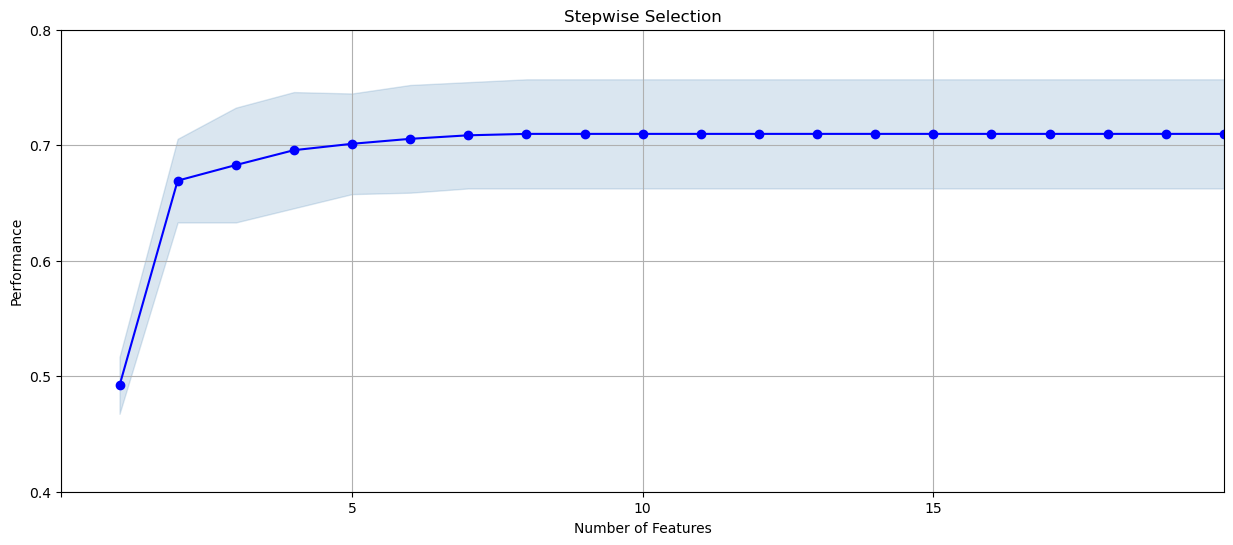

In [149]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
# plt.xticks(np.arange(0, len(X.columns), step=5))
plt.xticks(np.arange(0, num_wrapper, step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([.4,.8])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('performance_nvars.png')
plt.show()

In [150]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [151]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))[0]
# You might also need this following line. It converts a list to a string
#         ordered_vars_FS.loc[i+1,'variable name'] = ordered_vars_FS.loc[i+1,'variable name'][0]

In [152]:
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(21,)","[0.5165644171779141, 0.46748466257668714]",0.492025,"(Cardnum_unique_count_for_card_state_1,)",0.105587,0.02454,0.02454,1.0,Cardnum_unique_count_for_card_state_1
2,"(21, 107)","[0.7055214723926381, 0.6331288343558282]",0.669325,"(Cardnum_unique_count_for_card_state_1, Card_M...",0.15574,0.036196,0.036196,2.0,Card_Merchdesc_total_7
3,"(21, 45, 107)","[0.7325153374233129, 0.6331288343558282]",0.682822,"(Cardnum_unique_count_for_card_state_1, Cardnu...",0.213813,0.049693,0.049693,3.0,Cardnum_count_1_by_30_sq
4,"(21, 45, 107, 118)","[0.7460122699386503, 0.645398773006135]",0.695706,"(Cardnum_unique_count_for_card_state_1, Cardnu...",0.216452,0.050307,0.050307,4.0,Cardnum_max_14
5,"(21, 26, 45, 107, 118)","[0.7447852760736197, 0.6576687116564417]",0.701227,"(Cardnum_unique_count_for_card_state_1, Card_d...",0.187416,0.043558,0.043558,5.0,Card_dow_vdratio_0by7
6,"(21, 26, 45, 101, 107, 118)","[0.7521472392638037, 0.6588957055214724]",0.705521,"(Cardnum_unique_count_for_card_state_1, Card_d...",0.200614,0.046626,0.046626,6.0,card_state_max_7
7,"(21, 26, 45, 101, 107, 118, 125)","[0.754601226993865, 0.6625766871165644]",0.708589,"(Cardnum_unique_count_for_card_state_1, Card_d...",0.197975,0.046012,0.046012,7.0,card_zip_count_1_by_60_sq
8,"(21, 26, 45, 101, 107, 118, 125, 137)","[0.7570552147239263, 0.6625766871165644]",0.709816,"(Cardnum_unique_count_for_card_state_1, Card_d...",0.203254,0.047239,0.047239,8.0,Merchnum_desc_total_3
9,"(21, 26, 28, 45, 101, 107, 118, 125, 137)","[0.7570552147239263, 0.6625766871165644]",0.709816,"(Cardnum_unique_count_for_card_state_1, Card_d...",0.203254,0.047239,0.047239,9.0,Cardnum_unique_count_for_card_state_3
10,"(21, 26, 28, 31, 45, 101, 107, 118, 125, 137)","[0.7570552147239263, 0.6625766871165644]",0.709816,"(Cardnum_unique_count_for_card_state_1, Card_d...",0.203254,0.047239,0.047239,10.0,Cardnum_actual/toal_1


In [153]:
ordered_vars_FS.to_csv('Wrapper_selection_info.csv', index=False)

In [154]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)
vars_keep

1      Cardnum_unique_count_for_card_state_1
2                     Card_Merchdesc_total_7
3                   Cardnum_count_1_by_30_sq
4                             Cardnum_max_14
5                      Card_dow_vdratio_0by7
6                           card_state_max_7
7                  card_zip_count_1_by_60_sq
8                      Merchnum_desc_total_3
9      Cardnum_unique_count_for_card_state_3
10                     Cardnum_actual/toal_1
11     Cardnum_unique_count_for_card_state_7
12                          Cardnum_count_14
13                         Card_dow_count_14
14       Cardnum_unique_count_for_card_zip_7
15       Cardnum_unique_count_for_Merchnum_7
16                         Cardnum_day_since
17                        Card_dow_day_since
18    Cardnum_unique_count_for_card_state_14
19                      Cardnum_actual/max_1
20      Cardnum_unique_count_for_card_zip_14
Name: variable name, dtype: object

In [155]:
filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score

,filter score
variable,
Cardnum_total_3,0.621932
Cardnum_total_1,0.619658
Cardnum_total_0,0.591318
Cardnum_count_1,0.567429
Cardnum_total_7,0.564245
...,...
card_merch_unique_count_for_card_state_7,0.000088
card_merch_unique_count_for_card_state_3,0.000063
merch_zip_unique_count_for_merch_state_14,0.000025


In [156]:
vars_keep_sorted = pd.DataFrame(vars_keep_list)
vars_keep_sorted.columns=['variable']
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()

""
variable
Cardnum_unique_count_for_card_state_1
Card_Merchdesc_total_7
Cardnum_count_1_by_30_sq
Cardnum_max_14
Card_dow_vdratio_0by7


In [157]:
vars_keep_sorted = pd.concat([vars_keep_sorted,filter_score],axis=1,join='inner')

In [158]:
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['index'] = vars_keep_sorted['index'] + 1
vars_keep_sorted.rename(columns={'index':'wrapper order'},inplace=True)
vars_keep_sorted.to_csv('vars_keep_sorted.csv',index=False)
vars_keep_sorted

,wrapper order,variable,filter score
0,1,Cardnum_unique_count_for_card_state_1,0.476067
1,2,Card_Merchdesc_total_7,0.324631
2,3,Cardnum_count_1_by_30_sq,0.428229
3,4,Cardnum_max_14,0.318826
4,5,Card_dow_vdratio_0by7,0.467961
5,6,card_state_max_7,0.329132
6,7,card_zip_count_1_by_60_sq,0.314822
7,8,Merchnum_desc_total_3,0.308586
8,9,Cardnum_unique_count_for_card_state_3,0.466410
9,10,Cardnum_actual/toal_1,0.459715


In [159]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['Cardnum_unique_count_for_card_state_1',
 'Card_Merchdesc_total_7',
 'Cardnum_count_1_by_30_sq',
 'Cardnum_max_14',
 'Card_dow_vdratio_0by7',
 'card_state_max_7',
 'card_zip_count_1_by_60_sq',
 'Merchnum_desc_total_3',
 'Cardnum_unique_count_for_card_state_3',
 'Cardnum_actual/toal_1',
 'Cardnum_unique_count_for_card_state_7',
 'Cardnum_count_14',
 'Card_dow_count_14',
 'Cardnum_unique_count_for_card_zip_7',
 'Cardnum_unique_count_for_Merchnum_7',
 'Cardnum_day_since',
 'Card_dow_day_since',
 'Cardnum_unique_count_for_card_state_14',
 'Cardnum_actual/max_1',
 'Cardnum_unique_count_for_card_zip_14',
 'Recnum',
 'Fraud']

In [160]:
filter_score

,filter score
variable,
Cardnum_total_3,0.621932
Cardnum_total_1,0.619658
Cardnum_total_0,0.591318
Cardnum_count_1,0.567429
Cardnum_total_7,0.564245
...,...
card_merch_unique_count_for_card_state_7,0.000088
card_merch_unique_count_for_card_state_3,0.000063
merch_zip_unique_count_for_merch_state_14,0.000025


In [161]:
%%time
df = pd.read_csv(file_name)
df.shape

CPU times: user 8.09 s, sys: 2.27 s, total: 10.4 s
Wall time: 15.2 s


(97496, 1330)

In [162]:
df_keep = df.filter(vars_keep_list, axis=1)
# df_keep = df[df.index.isin(vars_keep_list)]
print(df_keep.shape)

(97496, 22)


In [163]:
df_keep.to_csv('vars_final.csv',index=False)

In [164]:
print("duration: ", dt.datetime.now() - start_time)

duration:  0:14:27.311468


In [37]:
%pwd

'/Users/stevecoggeshall/Documents/Teaching/Data sets/done/transactions/give to students 2024'

In [28]:
# Initial setup for the pricing simulation over 100 days
days = 100
prices_profnath = [2.0]  # Starting price for profnath on day 1
prices_bordeebooks = [1.0]  # Starting price for bordeebooks on day 1

# Pricing logic according to the strategy described
for day in range(1, days):
    new_price_bordeebooks = prices_profnath[day - 1] - 0.25  # bordeebooks prices at $0.25 less than profnath's previous day price
    new_price_profnath = prices_bordeebooks[day - 1] + 1.00  # profnath prices at $1.00 more than bordeebooks' previous day price
    
    prices_bordeebooks.append(new_price_bordeebooks)
    prices_profnath.append(new_price_profnath)

prices_bordeebooks[-1], prices_profnath[-1] 


(38.5, 38.75)